# NYC Apartment Search - Group 1

### Purpose of the Project:
The project uses data-driven approaches to analyze and visualize New York City apartment data, 311 complaints, and urban forestry data to help understand urban living dynamics. This analysis is intended to aid in making informed decisions about apartment rentals based on environmental and urban living conditions.

### Sections and Key Functions:
1. **Setup**
   - Initializes the environment with necessary libraries and settings.

2. **Part 1: Data Preprocessing**
   - Functions to load and clean data from various sources (ZIP codes, 311 complaints, tree census, Zillow rent data).
   - Quality checks and basic data explorations are conducted.

3. **Part 2: Storing Data**
   - Database setup functions to create tables and indices.
   - Functions to convert geometries for database insertion and to insert cleaned data into a PostgreSQL database.
   - Data retrieval functions to fetch and display samples from each database table.

4. **Part 3: Understanding the Data**
   - Functions to execute SQL queries and to extract meaningful insights from the database.
   - Various SQL queries analyze the relationship between apartment prices, complaints, and tree census data.

5. **Part 4: Visualizing the Data**
   - Multiple visualizations to represent data insights graphically, including trends over time and spatial distributions.

## Setup

In [130]:
# Standard library imports
import os
import pathlib
import subprocess
from datetime import datetime, timedelta
from typing import Tuple

# Third-party imports
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
import pandas as pd
import requests
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.engine.base import Engine
from shapely.geometry import Point
from geoalchemy2 import Geometry, WKTElement

In [131]:
# Path configuration
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"
QUERY_DIR = pathlib.Path("queries")  # Directory for saving DB queries

# API configuration
APP_TOKEN = "J9t5fS2TcfDISWng9WsnCdvCP"
COMPLAINTS_URL = 'https://data.cityofnewyork.us/resource/erm2-nwe9.geojson'
TREES_URL = 'https://data.cityofnewyork.us/resource/uvpi-gqnh.geojson'

# Database configuration
DB_NAME = "nyc_data"
DB_USER = "williamsjs"
DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
engine = create_engine(DB_URL)

In [132]:
def ensure_directory_exists(directory: pathlib.Path):
    """Ensure that a directory exists; if not, create it."""
    try:
        directory.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        print(f"Error creating directory {directory}: {e}")

# Make sure the directories exist
ensure_directory_exists(DATA_DIR)
ensure_directory_exists(QUERY_DIR)

## Part 1: Data Preprocessing

The first part of the data cleaning process involves the following steps:

1. **Reading and cleaning the Zillow rental data**:
   - Loading the Zillow data from a CSV file
   - Melting the data so that each row represents a unique date-region pair
   - Filtering the data to include only New York City and the relevant date range (February 2022 to January 2024)
   - Keeping the required columns (zipcode, city, date, rent price) and renaming them
   - Converting the "zipcode" column to a string type and the "date" column to a datetime type

2. **Reading and cleaning the zipcode data**
3. **Downloading, cleaning, and filtering the 311 complaints data and tree data**
4. **Filtering all the datasets to include only the cleaned zipcode data**

5. **Performing data quality checks**:
   - Checking for null values in each dataset
   - Checking for duplicate entries in each dataset
   - Cross-referencing the zipcodes across the datasets to ensure consistency
6. **Show information and first 5 entries of each dataset**.

Overall, the purpose of this part of the code is to extract, clean, and integrate the necessary information from the original data sources, preparing the data for further analysis. It involves key steps such as data loading, data cleaning, data filtering, and data quality checks.

#### The `read_and_clean_zipcode_data()` function 
reads in a shapefile containing zipcode data, cleans and preprocesses the data, and returns a GeoDataFrame with unique zipcodes and their corresponding geometries. 

The key steps are:

1. Reading the shapefile using Geopandas, a library for working with geospatial data.
2. Selecting the relevant columns (zipcode and geometry) and renaming the 'ZIPCODE' column to 'zipcode' for better readability.
3. Converting the coordinate reference system (CRS) of the GeoDataFrame to EPSG:4326 (WGS84) for consistency.
4. Removing any duplicate zipcode entries, keeping only the first occurrence of each unique zipcode.

In [133]:
def read_and_clean_zipcode_data() -> gpd.GeoDataFrame:
    """
    Read and clean zipcode data from a shapefile.
    
    Returns:
        GeoDataFrame: A cleaned GeoDataFrame containing unique zipcodes and their geometries.
    """
    # Read the shapefile using Geopandas
    zipcode_data = gpd.read_file(ZIPCODE_DATA_FILE)
    
    # Select relevant columns and rename them
    zipcode_cleaned = zipcode_data[['ZIPCODE', 'geometry']].rename(columns={'ZIPCODE': 'zipcode'})
    
    # Convert CRS to EPSG:4326 for consistency
    zipcode_cleaned = zipcode_cleaned.to_crs(epsg=4326)
    
    # Remove duplicate zipcodes, keeping the first occurrence
    zipcode_cleaned = zipcode_cleaned.drop_duplicates(subset=['zipcode'], keep='first')
    
    return zipcode_cleaned

#### The `download_and_clean_311_data()` function 
fetches 311 complaint data from the NYC Open Data API, cleans and preprocesses the data, and returns a GeoDataFrame containing the cleaned 311 complaints.

The key steps are:
1. Defining the API parameters to fetch 311 complaint data within a specific date range and with valid latitude/longitude coordinates.
2. Sending a request to the API and handling any errors that may occur during the download.
3. Creating a GeoDataFrame from the API response and setting the appropriate coordinate reference system (EPSG:4326).
4. Selecting and renaming the relevant columns, and dropping any rows with missing zipcodes.
5. Converting the 'created_date' column from a string to a date format.

In [134]:
def download_and_clean_311_data() -> gpd.GeoDataFrame:
    """
    Download and clean 311 complaint data from the NYC Open Data API.
    
    Returns:
        GeoDataFrame: A cleaned GeoDataFrame containing 311 complaints with relevant fields and valid zipcodes.
    """
    # API parameters for fetching data
    complaints_params = {
        '$$app_token': APP_TOKEN,
        '$where': 'created_date >= "2022-02-01T00:00:00.000" AND created_date <= "2024-02-29T00:00:00.000" AND latitude IS NOT NULL',
        '$limit': 1000000
    }
    
    # Requesting data from the API
    complaints_response = requests.get(COMPLAINTS_URL, params=complaints_params)
    if complaints_response.status_code != 200:
        raise Exception("Failed to download data")

    # Create a GeoDataFrame from the response
    complaints_data = gpd.GeoDataFrame.from_features(complaints_response.json()['features']).set_crs(epsg=4326)
    
    # Select and rename columns, and drop rows without zipcodes
    complaints_cleaned = complaints_data[['unique_key', 'created_date', 'complaint_type', 'incident_zip', 'geometry']].rename(columns={
        'unique_key': 'unique_id', 
        'incident_zip': 'zipcode'
    }).dropna(subset=['zipcode'])
    
    # Convert 'created_date' from string to date
    complaints_cleaned['created_date'] = pd.to_datetime(complaints_cleaned['created_date']).dt.date
    
    return complaints_cleaned

#### The `download_and_clean_tree_data()` function 
fetches tree data from the NYC Open Data API, cleans and preprocesses the data, and returns a GeoDataFrame containing the cleaned tree data.

The key steps are:

1. Defining the API parameters to fetch tree data, with a limit of 10 million records.
2. Sending a request to the API and handling any errors that may occur during the download.
3. Creating a GeoDataFrame from the API response and dropping any rows where the latitude or longitude is missing.
4. Converting the latitude and longitude columns to float and creating geometry points from them.
5. Selecting and renaming the relevant columns, and dropping any rows where critical information (zipcode, health, or species) is missing.
6. Setting the coordinate reference system (EPSG:4326) for the GeoDataFrame.

In [135]:
def download_and_clean_tree_data() -> gpd.GeoDataFrame:
    """
    Download and clean tree data from the NYC Open Data API.
    
    Returns:
        GeoDataFrame: A cleaned GeoDataFrame containing tree data with geometries created from latitude and longitude.
    """
    trees_params = {
        '$$app_token': APP_TOKEN,
        '$limit': 10000000
    }
    
    trees_response = requests.get(TREES_URL, params=trees_params)
    if trees_response.status_code != 200:
        print(f"Failed to download tree data. Status code: {trees_response.status_code}")
        return None

    # Create a GeoDataFrame from the JSON response
    trees_data = gpd.GeoDataFrame.from_features(trees_response.json())

    # Drop rows where latitude or longitude is NaN, and convert them to float
    trees_data.dropna(subset=['latitude', 'longitude'], inplace=True)
    trees_data['latitude'] = trees_data['latitude'].astype(float)
    trees_data['longitude'] = trees_data['longitude'].astype(float)

    # Create geometry points from latitude and longitude
    trees_data['geometry'] = trees_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # Select and rename columns, drop rows where any critical information is missing
    trees_cleaned = trees_data[['tree_id', 'spc_common', 'health', 'status', 'zipcode', 'geometry']].rename(
        columns={'spc_common': 'species'}
    )
    trees_cleaned['zipcode'] = trees_cleaned['zipcode'].astype(str)
    trees_cleaned.crs = 'EPSG:4326'
    trees_cleaned.dropna(subset=['zipcode', 'health', 'species'], inplace=True)

    return trees_cleaned

#### The `read_and_clean_zillow_data()` function 
reads Zillow rental data for New York City from a CSV file, cleans and preprocesses the data, and returns a cleaned DataFrame.

The key steps are:

1. Loading the Zillow data from a CSV file into a DataFrame.
2. Melting the data so that each row represents a unique date-region pair, making it easier to work with.
3. Filtering the data to include only New York City and selecting the relevant date range (February 2022 to January 2024).
4. Keeping only the required columns (zipcode, city, data_date, rent_price) and renaming them for better readability.
5. Converting the 'zipcode' column to a string and the 'data_date' column to a datetime format.

In [136]:
def read_and_clean_zillow_data() -> pd.DataFrame:
    """
    Read and clean Zillow rental data for New York City.
    
    Returns:
        DataFrame: A cleaned DataFrame containing Zillow rental data with selected columns and filtered dates.
    """
    # Load Zillow data from a CSV file
    zillow_data = pd.read_csv(ZILLOW_DATA_FILE)
    
    # Melt the data so that every row is a unique date-region pair
    id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']
    melted_data = pd.melt(zillow_data, id_vars=id_vars, var_name='data_date', value_name='rent_price')
    
    # Filter for New York City data and select relevant dates
    zillow_cleaned = melted_data[
        (melted_data['City'] == 'New York') &
        (melted_data['data_date'] >= '2022-02-01') &
        (melted_data['data_date'] <= '2024-01-31')
    ]
    
    # Keep only the required columns and rename them
    zillow_cleaned = zillow_cleaned[['RegionName', 'City', 'data_date', 'rent_price']].rename(
        columns={'RegionName': 'zipcode', 'City': 'city', 'data_date': 'data_date', 'rent_price': 'rent_price'}
    ).dropna()
    
    # Convert data types
    zillow_cleaned['zipcode'] = zillow_cleaned['zipcode'].astype(str)
    zillow_cleaned['data_date'] = pd.to_datetime(zillow_cleaned['data_date'])

    return zillow_cleaned

#### The `load_and_clean_all_data()` function 
is responsible for loading and cleaning multiple datasets, including zip codes, Zillow rental data, 311 complaints, and tree data. It then filters all the datasets to only include entries corresponding to the cleaned zip code data.

The key steps are:

1. Reading and cleaning the zip code data using the `read_and_clean_zipcode_data()` function.
2. Reading, cleaning, and filtering the Zillow rental data using the `read_and_clean_zillow_data()` function, ensuring that only the data for the cleaned zip codes is retained.
3. Downloading, cleaning, and filtering the 311 complaints data using the `download_and_clean_311_data()` function, again ensuring that only the data for the cleaned zip codes is kept.
4. Downloading, cleaning, and filtering the tree data using the `download_and_clean_tree_data()` function, keeping only the data for the cleaned zip codes.

In [137]:
def load_and_clean_all_data() -> Tuple[gpd.GeoDataFrame, pd.DataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Load and clean all relevant datasets including zip codes, rental data, 311 complaints, and tree data,
    filtering them to only include entries corresponding to the cleaned zip code data.
    
    Returns:
        Tuple[GeoDataFrame, DataFrame, GeoDataFrame, GeoDataFrame]: A tuple containing the cleaned data for
        zip codes, Zillow rental, 311 complaints, and tree data respectively.
    """
    # Read and clean zipcode data
    zipcode_data = read_and_clean_zipcode_data()
    
    # Read, clean and filter Zillow rental data
    zillow_data = read_and_clean_zillow_data()
    zillow_data = zillow_data[zillow_data['zipcode'].isin(zipcode_data['zipcode'])]
    
    # Download, clean and filter 311 complaints data
    complaints_data = download_and_clean_311_data()
    if complaints_data is not None:
        complaints_data = complaints_data[complaints_data['zipcode'].isin(zipcode_data['zipcode'])]
    
    # Download, clean and filter tree data
    tree_data = download_and_clean_tree_data()
    if tree_data is not None:
        tree_data = tree_data[tree_data['zipcode'].isin(zipcode_data['zipcode'])]

    return zipcode_data, zillow_data, complaints_data, tree_data

#### Load and clean all data sets

In [138]:
# Load and clean all data sets
zipcode_data, zillow_data, complaints_data, tree_data = load_and_clean_all_data()

#### The `check_data_quality()` function 
performs a series of data quality checks on the loaded datasets, including:

1. Checking for null values in each dataset (zipcode_data, zillow_data, complaints_data, and tree_data).
2. Checking for duplicate entries in each dataset, such as duplicate zipcodes, tree IDs, and unique IDs.
3. Cross-referencing the zipcodes across the datasets to ensure that all zipcodes in the Zillow rental, 311 complaints, and tree data are present in the cleaned zipcode_data.

In [139]:
def check_data_quality():
    """
    Perform data quality checks on the loaded datasets.
    """

    # Check for null values in each dataset
    print("Null values in zipcode_data:", zipcode_data.isnull().sum())
    print("Null values in zillow_data:", zillow_data.isnull().sum())
    if complaints_data is not None:
        print("Null values in complaints_data:", complaints_data.isnull().sum())
    if tree_data is not None:
        print("Null values in tree_data:", tree_data.isnull().sum())

    # Check for duplicate entries
    print("Duplicate zipcodes in zipcode_data:", zipcode_data['zipcode'].duplicated().sum())
    if tree_data is not None:
        print("Duplicate tree_ids in tree_data:", tree_data['tree_id'].duplicated().sum())
    if complaints_data is not None:
        print("Duplicate unique_ids in complaints_data:", complaints_data['unique_id'].duplicated().sum())
    print("Duplicate zipcodes in zillow_data:", zillow_data['zipcode'].duplicated().sum())

    # Cross-reference zipcodes across datasets
    if zillow_data is not None and zipcode_data is not None:
        print("Are all zillow_data zipcodes in zipcode_data?", all(zillow_data['zipcode'].isin(zipcode_data['zipcode'].unique())))
    if complaints_data is not None and zipcode_data is not None:
        print("Are all complaints_data zipcodes in zipcode_data?", all(complaints_data['zipcode'].isin(zipcode_data['zipcode'].unique())))
    if tree_data is not None and zipcode_data is not None:
        print("Are all tree_data zipcodes in zipcode_data?", all(tree_data['zipcode'].isin(zipcode_data['zipcode'].unique())))

# Run the data quality checks
check_data_quality()

Null values in zipcode_data: zipcode     0
geometry    0
dtype: int64
Null values in zillow_data: zipcode       0
city          0
data_date     0
rent_price    0
dtype: int64
Null values in complaints_data: unique_id         0
created_date      0
complaint_type    0
zipcode           0
geometry          0
dtype: int64
Null values in tree_data: tree_id     0
species     0
health      0
status      0
zipcode     0
geometry    0
dtype: int64
Duplicate zipcodes in zipcode_data: 0
Duplicate tree_ids in tree_data: 0
Duplicate unique_ids in complaints_data: 0
Duplicate zipcodes in zillow_data: 2711
Are all zillow_data zipcodes in zipcode_data? True
Are all complaints_data zipcodes in zipcode_data? True
Are all tree_data zipcodes in zipcode_data? True


#### Show basic info about zipcode_data

In [140]:
zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 248 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   248 non-null    object  
 1   geometry  248 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 5.8+ KB


#### Show first 5 entries about zipcode_data

In [141]:
zipcode_data.head()

,zipcode,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


#### Show basic info about complaints_data

In [142]:
complaints_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 994175 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   unique_id       994175 non-null  object  
 1   created_date    994175 non-null  object  
 2   complaint_type  994175 non-null  object  
 3   zipcode         994175 non-null  object  
 4   geometry        994175 non-null  geometry
dtypes: geometry(1), object(4)
memory usage: 45.5+ MB


#### Show first 5 entries about complaints_data

In [143]:
complaints_data.head()

,unique_id,created_date,complaint_type,zipcode,geometry
0,60447538,2024-02-29,Street Light Condition,10462,POINT (-73.86358 40.84128)
1,60442341,2024-02-28,Illegal Parking,10465,POINT (-73.80765 40.82001)
2,60444918,2024-02-28,Noise,11210,POINT (-73.94507 40.61721)
3,60439459,2024-02-28,Street Light Condition,11417,POINT (-73.85511 40.67365)
4,60444367,2024-02-28,UNSANITARY CONDITION,10039,POINT (-73.94092 40.82595)


#### Show basic info about tree_data

In [144]:
tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651235 entries, 0 to 683787
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   tree_id   651235 non-null  object  
 1   species   651235 non-null  object  
 2   health    651235 non-null  object  
 3   status    651235 non-null  object  
 4   zipcode   651235 non-null  object  
 5   geometry  651235 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 34.8+ MB


#### Show first 5 entries about tree_data

In [145]:
tree_data.head()

,tree_id,species,health,status,zipcode,geometry
0,180683,red maple,Fair,Alive,11375,POINT (-73.84422 40.72309)
1,200540,pin oak,Fair,Alive,11357,POINT (-73.81868 40.79411)
2,204026,honeylocust,Good,Alive,11211,POINT (-73.93661 40.71758)
3,204337,honeylocust,Good,Alive,11211,POINT (-73.93446 40.71354)
4,189565,American linden,Good,Alive,11215,POINT (-73.97598 40.66678)


#### Show basic info about zillow_data

In [146]:
zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2855 entries, 563725 to 722886
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   zipcode     2855 non-null   object        
 1   city        2855 non-null   object        
 2   data_date   2855 non-null   datetime64[ns]
 3   rent_price  2855 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 111.5+ KB


#### Show first 5 entries about zillow_data

In [147]:
zillow_data.head()

,zipcode,city,data_date,rent_price
563725,11385,New York,2022-02-28,2511.479296
563734,10467,New York,2022-02-28,1607.726640
563735,11373,New York,2022-02-28,2274.638306
563736,11226,New York,2022-02-28,2415.357857
563737,11207,New York,2022-02-28,2503.056202


## Part 2: Storing Data

The second part of the data storage process involves the following steps:

1. **Defining and Applying the Database Schema `(define_and_apply_schema())`**:
   - Created four tables: zipcode_data, complaints_data, tree_data, and zillow_data
   - Defined the table structure, including primary keys, foreign keys, and other constraints
   - Created spatial indexes on the geometry fields to improve query performance
   - Wrote the defined schema to an SQL file and executed it to apply the schema to the database

2. **Converting Geometries for Database Insertion `(convert_geom())`**:
   - Converted the geometry data in the GeoDataFrame to Well-Known Text (WKT) format for storage in the database

3. **Inserting Data into the Database `(insert_data())`**:
   - Used the pandas `to_sql()` method to insert the cleaned datasets into the corresponding database tables
   - Specified the data types, ensuring the geometry data is stored correctly
   - Handled any exceptions that may occur during the data insertion process

4. **Fetching Data from the Database `(fetch_data())`**:
   - Defined a generic function to use pandas' `read_sql_query()` to retrieve data from the database based on a provided SQL query
   - Provided an example usage, querying the row counts for each of the tables and returning the results

In summary, this part of the code completed the process of storing the cleaned data in a PostgreSQL database, and provided related read and write interfaces, laying the foundation for further data analysis and exploration.

#### The `create_database()` function 

performs the following key steps:

1. Creates a new PostgreSQL database named 'nyc_data' using the `createdb` command.
2. Adds the PostGIS extension to the newly created database using the `CREATE EXTENSION postgis;` SQL command.
3. If the database creation and PostGIS extension addition are successful, it prints a success message. If there is an error, it prints the error message.

In [148]:
def create_database():
    """
    Creates a new PostgreSQL database named 'nyc_data' and adds PostGIS extension.
    """
    try:
        subprocess.run(["createdb", DB_NAME], check=True)
        subprocess.run(["psql", "--dbname", DB_NAME, "-c", "CREATE EXTENSION postgis;"], check=True)
        print("Database and PostGIS extension created successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to create database or PostGIS extension: {e}")

#### The `define_and_apply_schema()` function 

performs the following key steps:

1. It defines the schema for the database, including the creation of four tables: `zipcode_data`, `complaints_data`, `tree_data`, and `zillow_data`. Each table has a specific set of columns and constraints, such as primary keys and foreign key relationships.
2. The function also creates spatial indices on the geometry columns of the tables, which will improve the performance of spatial queries.
3. The defined schema is written to a SQL file, and then executed using the `psql` command to apply the schema to the 'nyc_data' database.

In [149]:
def define_and_apply_schema():
    """
    Defines the schema for the database and applies it using SQL file execution.
    """
    schema_sql = """
        -- Drop existing tables and indices if they exist
        DROP INDEX IF EXISTS idx_zipcode_geom CASCADE;
        DROP INDEX IF EXISTS idx_complaints_geom CASCADE;
        DROP INDEX IF EXISTS idx_tree_geom CASCADE;
        DROP TABLE IF EXISTS complaints_data CASCADE;
        DROP TABLE IF EXISTS tree_data CASCADE;
        DROP TABLE IF EXISTS zillow_data CASCADE;
        DROP TABLE IF EXISTS zipcode_data CASCADE;

        -- Create tables
        CREATE TABLE zipcode_data (
            zipcode TEXT PRIMARY KEY,
            geom GEOMETRY
        );

        CREATE TABLE complaints_data (
            unique_id BIGINT PRIMARY KEY,
            created_date DATE,
            complaint_type TEXT,
            zipcode TEXT,
            geom GEOMETRY,
            FOREIGN KEY (zipcode) REFERENCES zipcode_data(zipcode)
        );

        CREATE TABLE tree_data (
            tree_id BIGINT PRIMARY KEY,
            species TEXT,
            health TEXT,
            status TEXT,
            zipcode TEXT,
            geom GEOMETRY,
            FOREIGN KEY (zipcode) REFERENCES zipcode_data(zipcode)
        );

        CREATE TABLE zillow_data (
            zipcode TEXT,
            city TEXT,
            data_date DATE,
            rent_price NUMERIC,
            FOREIGN KEY (zipcode) REFERENCES zipcode_data(zipcode),
            PRIMARY KEY (zipcode, data_date)
        );

        -- Create spatial indices
        CREATE INDEX idx_zipcode_geom ON zipcode_data USING gist(geom);
        CREATE INDEX idx_complaints_geom ON complaints_data USING gist(geom);
        CREATE INDEX idx_tree_geom ON tree_data USING gist(geom);
    """
    
    # Write the SQL schema to a file
    with open("schema.sql", "w") as file:
        file.write(schema_sql)
    
    # Execute the SQL schema file
    try:
        subprocess.run(["psql", "-d", DB_NAME, "-f", "schema.sql"], check=True)
        print("Database schema applied successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to apply database schema: {e}")
        
if __name__ == "__main__":
    create_database()
    define_and_apply_schema()

Failed to create database or PostGIS extension: Command '['createdb', 'nyc_data']' returned non-zero exit status 1.
DROP INDEX
DROP INDEX
DROP INDEX
DROP TABLE
DROP TABLE
DROP TABLE
DROP TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE INDEX
CREATE INDEX
CREATE INDEX
Database schema applied successfully.


createdb: error: database creation failed: ERROR:  database "nyc_data" already exists


#### The `convert_geom()` function 
performs the following key steps:

1. It takes a GeoDataFrame as input, which contains a 'geometry' column with spatial data.
2. The function checks if the 'geometry' column exists in the input DataFrame.
3. If the 'geometry' column is present, it applies the `WKTElement()` function to each geometry object in the column, converting it to a Well-Known Text (WKT) representation.
4. The function then renames the 'geometry' column to 'geom' and drops the original 'geometry' column, returning a new DataFrame with the converted geometries.

In [150]:
def convert_geom(data: gpd.GeoDataFrame) -> pd.DataFrame:
    """
    Convert geometries to WKTElement for database insertion.

    Args:
        data (GeoDataFrame): The geopandas DataFrame containing the 'geometry' column.

    Returns:
        DataFrame: A pandas DataFrame with converted geometry to WKTElement and renamed to 'geom'.
    """
    if 'geometry' in data.columns:
        data['geom'] = data['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
        return data.drop(columns=['geometry'])
    return data

#### The `insert_data()` function 
performs the following key steps:

1. It takes a pandas DataFrame, the name of the target database table, and an optional dictionary of SQLAlchemy data types as input.
2. The function uses the `to_sql()` method of the DataFrame to insert the data into the specified table in the database.
3. The `if_exists='append'` parameter ensures that the data is appended to the table, rather than overwriting any existing data.
4. The `index=False` parameter ensures that the DataFrame index is not included in the insert.
5. The `dtype` parameter is used to specify the SQL column types for the data, which is particularly important for the 'geom' column containing the spatial data.
6. If the data insertion is successful, it prints a success message. If there is an error, it prints the error message.
7. The code calls the `insert_data()` function for each of the cleaned datasets (`zipcode_data`, `complaints_data`, `tree_data`, and `zillow_data`), using the `convert_geom()` function to convert the geometries to the appropriate format before insertion.

In [151]:
def insert_data(df: pd.DataFrame, table_name: str, dtype: dict = None) -> None:
    """
    Inserts data into a database table.

    Args:
        df (DataFrame): The DataFrame to insert into the database.
        table_name (str): The name of the target database table.
        dtype (dict): A dictionary of SQLAlchemy types to specify SQL column types.

    Raises:
        Exception: If the data insertion fails, it raises an exception with the error message.
    """
    try:
        df.to_sql(table_name, engine, if_exists='append', index=False, dtype=dtype)
        print(f"{table_name} inserted successfully.")
    except Exception as e:
        print(f"Failed to insert {table_name}: {str(e)}")

# use the above functions to insert datasets to database
insert_data(convert_geom(zipcode_data), 'zipcode_data', {'geom': Geometry('GEOMETRY', srid=4326)})
insert_data(convert_geom(complaints_data), 'complaints_data', {'geom': Geometry('GEOMETRY', srid=4326)})
insert_data(convert_geom(tree_data), 'tree_data', {'geom': Geometry('GEOMETRY', srid=4326)})
insert_data(zillow_data, 'zillow_data')

print("Database setup and data insertion complete.")

zipcode_data inserted successfully.
complaints_data inserted successfully.
tree_data inserted successfully.
zillow_data inserted successfully.
Database setup and data insertion complete.


#### The `fetch_data()` function 
performs the following key steps:

1. It takes a SQL query and a database engine connection as input.
2. The function uses the `pd.read_sql_query()` method to execute the provided SQL query and fetch the resulting data as a pandas DataFrame.
3. If there is an error during the data fetch, the function prints the error message and returns an empty DataFrame.

In [152]:
def fetch_data(query: str, engine: Engine) -> pd.DataFrame:
    """
    Fetches data from the database based on the provided SQL query.

    Args:
        query (str): The SQL query to be executed.
        engine (Engine): The database engine connection used to execute the query.

    Returns:
        DataFrame: A DataFrame containing the results of the SQL query.
    """
    try:
        return pd.read_sql_query(query, con=engine)
    except Exception as e:
        print(f"Failed to fetch data: {str(e)}")
        return pd.DataFrame()  # Return an empty DataFrame on failure

# Example usage of the fetch_data function
query = """
    SELECT 'zipcode_data' AS table_name, COUNT(*) AS total_rows FROM zipcode_data UNION ALL
    SELECT 'complaints_data' AS table_name, COUNT(*) FROM complaints_data UNION ALL
    SELECT 'tree_data' AS table_name, COUNT(*) FROM tree_data UNION ALL
    SELECT 'zillow_data' AS table_name, COUNT(*) FROM zillow_data;
"""
row_counts = fetch_data(query, engine)

#### Print the row counts for each table

In [153]:
row_counts

,table_name,total_rows
0,zillow_data,2855
1,zipcode_data,248
2,tree_data,651235
3,complaints_data,994175


#### Fetch and print a sample from the 'zipcode_data' table

In [154]:
zipcode_sample = fetch_data("SELECT * FROM zipcode_data LIMIT 5;", engine)
zipcode_sample

,zipcode,geom
0,11436,0103000020E6100000010000009F0000002BFF7C059373...
1,11213,0103000020E610000001000000A2000000FB8CA252FE7B...
2,10009,0103000020E610000001000000A60000006853AC1F4D7E...
3,11212,0103000020E6100000010000001A01000024C269CAC979...
4,11225,0103000020E610000001000000A0000000DAA0A86E4F7D...


#### Fetch and print a sample from the 'complaints_data' table

In [155]:
complaints_sample = fetch_data("SELECT * FROM complaints_data LIMIT 5;", engine)
complaints_sample

,unique_id,created_date,complaint_type,zipcode,geom
0,60447538,2024-02-29,Street Light Condition,10462,0101000020E61000009D673EEC447752C08BAD18FFAE6B...
1,60442341,2024-02-28,Illegal Parking,10465,0101000020E6100000E82D2F79B07352C0E6812A0EF668...
2,60444918,2024-02-28,Noise,11210,0101000020E6100000E0E5FFF67B7C52C0D5279FCA004F...
3,60439459,2024-02-28,Street Light Condition,11417,0101000020E610000061656411BA7652C0FF8E711E3A56...
4,60444367,2024-02-28,UNSANITARY CONDITION,10039,0101000020E61000004C7BAA14387C52C0F14083ADB869...


#### Fetch and print a sample from the 'tree_data' table

In [156]:
tree_sample = fetch_data("SELECT * FROM tree_data LIMIT 5;", engine)
tree_sample

,tree_id,species,health,status,zipcode,geom
0,180683,red maple,Fair,Alive,11375,0101000020E6100000DE2B469F077652C0111468458E5C...
1,200540,pin oak,Fair,Alive,11357,0101000020E6100000D8A6883E657452C0FF861E6BA565...
2,204026,honeylocust,Good,Alive,11211,0101000020E6100000A22B6C61F17B52C00E4589AFD95B...
3,204337,honeylocust,Good,Alive,11211,0101000020E6100000BAAF3521CE7B52C08D024C32555B...
4,189565,American linden,Good,Alive,11215,0101000020E6100000E7AA3772767E52C0387340F95855...


#### Fetch and print a sample from the 'zillow_data' table

In [157]:
zillow_sample = fetch_data("SELECT * FROM zillow_data LIMIT 5;", engine)
zillow_sample

,zipcode,city,data_date,rent_price
0,11385,New York,2022-02-28,2511.479296
1,10467,New York,2022-02-28,1607.726640
2,11373,New York,2022-02-28,2274.638306
3,11226,New York,2022-02-28,2415.357857
4,11207,New York,2022-02-28,2503.056202


## Part 3: Understanding the Data


1. `QUERY1`: This query calculates the average rent price for each zipcode in the `zillow_data` table as of the date '2024-01-31'.

2. `QUERY2`: This query counts the number of trees for each zipcode in the `tree_data` table.

3. `QUERY3`: This query counts the number of complaints for each zipcode in the `complaints_data` table where the `created_date` is between '2024-01-01' and '2024-01-31'.

4. `QUERY4`: This query finds the correlation between rent, trees, and complaints by joining the results of the previous three queries. It focuses on the top and bottom 5 zipcodes by average rent as of '2024-01-31'.

5. `QUERY5`: This query calculates the percentage change in rent prices for each zipcode in the `zillow_data` table between the dates '2023-01-31' and '2024-01-31'.

6. `QUERY6`: This query calculates the percentage change in the number of trees for each zipcode in the `tree_data` table between the dates '2023-01-01' and '2024-01-01'.

These queries provide insights into the relationships between rent, trees, and complaints in the given data, as well as the changes in rent prices and tree counts over a one-year period from 2023 to 2024. The results can be used to analyze urban development and quality of life factors within the specified timeframe.

#### The `read_query()` function 
performs the following tasks:

1. It takes an SQL query (as a string) and a database engine connection as input parameters.
2. It attempts to execute the given SQL query using the provided database engine connection and returns the results as a pandas DataFrame.
3. If an exception occurs during the query execution, the function prints an error message and returns an empty pandas DataFrame instead of raising the exception.

In [158]:
def read_query(query: str, engine: Engine) -> pd.DataFrame:
    """
    Executes an SQL query and returns the results as a DataFrame.

    Args:
        query (str): The SQL query to execute.
        engine (Engine): The database engine connection to use for the query.

    Returns:
        DataFrame: A DataFrame containing the query results.
    """
    try:
        return pd.read_sql(query, con=engine)
    except Exception as e:
        print(f"Failed to execute query: {str(e)}")
        return pd.DataFrame()  # Return an empty DataFrame on error

### Query 1

1. It defines an SQL query, `QUERY1`, that retrieves the number of 311 complaints per zipcode in New York City for the period between March 2023 and February 2024. The query groups the complaints by zipcode and orders the results by the complaint count in descending order.

2. It writes the `QUERY1` to a SQL file within the specified `QUERY_DIR` directory. If the directory does not exist, it creates the directory and its parent directories as needed.

3. It executes the `QUERY1` using the `read_query()` function, which takes the query and the database engine connection as input, and returns the results as a pandas DataFrame, which is stored in the `complaint_counts` variable.

4. Finally, it returns the `complaint_counts` DataFrame, which can be used for further analysis or processing.

In [159]:
# Query 1: Number of 311 complaints per zip code
# Define the query for the number of 311 complaints per zip code
QUERY1 = """
    SELECT zipcode, COUNT(*) as complaint_count
    FROM complaints_data
    WHERE created_date >= '2023-03-01' AND created_date <= '2024-02-29'
    GROUP BY zipcode
    ORDER BY complaint_count DESC
"""

# Write the query to a SQL file within the specified directory
query_file = QUERY_DIR / "number_of_complaints_per_zipcode.sql"
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
with open(query_file, "w") as file:
    file.write(QUERY1)

# Execute the query and fetch the results
complaint_counts = read_query(QUERY1, engine)
complaint_counts

,zipcode,complaint_count
0,11226,17183
1,11201,16752
2,10467,16374
3,10468,15941
4,10457,15565
...,...,...
224,10174,1
225,10122,1
226,10177,1
227,10055,1


### Query 2

1. It defines an SQL query, `QUERY2`, that retrieves the top 10 zipcodes by tree count. The query groups the tree data by zipcode, counts the number of trees for each zipcode, orders the results by the tree count in descending order, and limits the output to the top 10 rows.

2. It writes the `QUERY2` to a SQL file within the specified `QUERY_DIR` directory. If the directory does not exist, it creates the directory and its parent directories as needed.

3. It executes the `QUERY2` using the `read_query()` function, which takes the query and the database engine connection as input, and returns the results as a pandas DataFrame, which is stored in the `top_tree_counts` variable.

4. Finally, it returns the `top_tree_counts` DataFrame, which can be used for further analysis or processing.

In [160]:
#Query 2: Top 10 zip codes by tree count
# Define the query for the top 10 zip codes by tree count
QUERY2 = """
    SELECT zipcode, COUNT(*) as tree_count
    FROM tree_data
    GROUP BY zipcode
    ORDER BY tree_count DESC
    LIMIT 10
"""

# Write the query to a SQL file within the specified directory
query_file2 = QUERY_DIR / "top_10_zipcodes_by_tree_count.sql"
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
with open(query_file2, "w") as file:
    file.write(QUERY2)

# Execute the query and fetch the results
top_tree_counts = read_query(QUERY2, engine)
top_tree_counts

,zipcode,tree_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8293
8,11208,7896
9,11434,7833


### Query 3

1. It defines an SQL query, `QUERY3`, that retrieves the average rent in the top 10 zipcodes with the most trees. The query uses a common table expression (CTE) to first identify the top 10 zipcodes by tree count, and then joins this with the Zillow rental data to calculate the average rent for each of those top 10 zipcodes.

2. It writes the `QUERY3` to a SQL file within the specified `QUERY_DIR` directory. If the directory does not exist, it creates the directory and its parent directories as needed.

3. It executes the `QUERY3` using the `read_query()` function, which takes the query and the database engine connection as input, and returns the results as a pandas DataFrame, which is stored in the `average_rent_in_greenest_areas` variable.

4. Finally, it returns the `average_rent_in_greenest_areas` DataFrame, which can be used for further analysis or processing.

In [161]:
#Query 3: Average rent in zip codes with the most trees
# Define the query for the average rent in zip codes with the most trees
QUERY3 = """
    WITH TopTreeZipCodes AS (
        SELECT zipcode, COUNT(*) as tree_count
        FROM tree_data
        GROUP BY zipcode
        ORDER BY tree_count DESC
        LIMIT 10
    )
    SELECT t.zipcode, TO_CHAR(AVG(z.rent_price), 'FM9,999,999.00') as average_rent
    FROM TopTreeZipCodes t
    JOIN zillow_data z ON t.zipcode = z.zipcode AND z.data_date = '2024-01-31'
    GROUP BY t.zipcode, t.tree_count
    ORDER BY t.tree_count DESC
"""

# Write the query to a SQL file within the specified directory
query_file3 = QUERY_DIR / "average_rent_in_greenest_areas.sql"
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
with open(query_file3, "w") as file:
    file.write(QUERY3)

# Execute the query and fetch the results
average_rent_in_greenest_areas = read_query(QUERY3, engine)
average_rent_in_greenest_areas

,zipcode,average_rent
0,10312,"2,003.33"
1,10314,"2,315.71"
2,10306,"2,188.89"
3,10309,"1,800.00"
4,11234,"2,791.67"
5,11385,"2,880.09"
6,11357,"2,575.00"
7,11207,"2,931.28"
8,11208,"2,704.61"
9,11434,"2,500.00"


### Query 4

1. It defines an SQL query, `QUERY4`, that retrieves the correlation between rent, trees, and complaints for the top and bottom 5 zipcodes by average rent. The query uses three common table expressions (CTEs) to:
   - Calculate the average rent and rent ranking for each zipcode
   - Count the number of trees for each zipcode
   - Count the number of complaints for each zipcode in January 2024

2. It joins the results of these three CTEs to create a final result set that includes the zipcode, average rent, tree count, and complaint count for the top and bottom 5 zipcodes by average rent.

3. It writes the `QUERY4` to a SQL file within the specified `QUERY_DIR` directory. If the directory does not exist, it creates the directory and its parent directories as needed.

4. It executes the `QUERY4` using the `read_query()` function, which takes the query and the database engine connection as input, and returns the results as a pandas DataFrame, which is stored in the `correlation_results` variable.

5. Finally, it returns the `correlation_results` DataFrame, which can be used for further analysis or processing.

In [162]:
# Query 4: Rent, trees, and complaints correlation
# Define the query for correlating rent, trees, and complaints
QUERY4 = """
    WITH RentRank AS (
        SELECT zipcode, AVG(rent_price) as average_rent,
        RANK() OVER (ORDER BY AVG(rent_price) DESC) rent_rank_desc,
        RANK() OVER (ORDER BY AVG(rent_price) ASC) rent_rank_asc
        FROM zillow_data
        WHERE data_date = '2024-01-31'
        GROUP BY zipcode
    ),
    TreeCount AS (
        SELECT zipcode, COUNT(*) as tree_count
        FROM tree_data
        GROUP BY zipcode
    ),
    ComplaintCount AS (
        SELECT zipcode, COUNT(*) as complaint_count
        FROM complaints_data
        WHERE created_date >= '2024-01-01' AND created_date < '2024-02-01'
        GROUP BY zipcode
    )
    SELECT r.zipcode,
    TO_CHAR(r.average_rent, 'FM9,999,999.00') as average_rent,
    t.tree_count,
    c.complaint_count
    FROM RentRank r
    JOIN TreeCount t ON r.zipcode = t.zipcode
    LEFT JOIN ComplaintCount c ON r.zipcode = c.zipcode
    WHERE r.rent_rank_desc <= 5 OR r.rent_rank_asc <= 5
    ORDER BY r.average_rent DESC
"""

# Write the query to a SQL file within the specified directory
query_file4 = QUERY_DIR / "rent_trees_complaints_correlation.sql"
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
with open(query_file4, "w") as file:
    file.write(QUERY4)

# Execute the query and fetch the results
correlation_results = read_query(QUERY4, engine)
correlation_results

,zipcode,average_rent,tree_count,complaint_count
0,10282,"6,906.67",230,61
1,10007,"6,836.26",338,321
2,10013,"6,282.18",1132,840
3,10069,"5,077.63",112,39
4,10004,"5,030.42",117,370
5,10453,"2,015.44",2874,3542
6,10312,"2,003.33",21356,989
7,10457,"1,957.78",3912,4729
8,11428,"1,937.50",2615,379
9,10309,"1,800.00",12105,743


### Query 5

1. It defines an SQL query, `QUERY5`, that retrieves the top 10 zipcodes with the most greenery (trees) using a spatial join. The query uses a common table expression (CTE) to:
   - Join the `tree_data` and `zipcode_data` tables using a spatial containment operation (`ST_Contains`) to determine which trees belong to each zipcode.
   - Count the number of trees for each zipcode.

2. It writes the `QUERY5` to a SQL file within the specified `QUERY_DIR` directory. If the directory does not exist, it creates the directory and its parent directories as needed.

3. It executes the `QUERY5` using the `read_query()` function, which takes the query and the database engine connection as input, and returns the results as a pandas DataFrame, which is stored in the `most_greenery_results` variable.

4. Finally, it returns the `most_greenery_results` DataFrame, which can be used for further analysis or processing.

In [163]:
# Query 5: Most greenery (take 2) using spatial join
# Define the query to find the zip codes with the most greenery using a spatial join
QUERY5 = """
    WITH TreeCount AS (
        SELECT z.zipcode, COUNT(*) as tree_count
        FROM tree_data t
        JOIN zipcode_data z ON ST_Contains(z.geom, t.geom)
        GROUP BY z.zipcode
    )
    SELECT zipcode, tree_count
    FROM TreeCount
    ORDER BY tree_count DESC
    LIMIT 10
"""

# Write the query to a SQL file within the specified directory
query_file5 = QUERY_DIR / "most_greenery_spatial.sql"
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
with open(query_file5, "w") as file:
    file.write(QUERY5)

# Execute the query and fetch the results
most_greenery_results = read_query(QUERY5, engine)
most_greenery_results

,zipcode,tree_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8294
8,11208,7897
9,11434,7833


### Query 6
1. It defines a central point using the `Point` class from the `shapely.geometry` module, with the coordinates (-73.96253174434912, 40.80737875669467).

2. It creates a buffer around the central point with a radius of 0.5 miles (approximately 804.672 meters) using the `buffer()` method of the `Point` object. This creates a circular area around the central point.

3. It constructs the SQL query `QUERY6` that retrieves the tree data (tree_id, species, health, status, and location) for all the trees within the buffered area. The `ST_DWithin()` function is used to check if the tree's geometry (`geom`) is within the buffered area.

4. It writes the `QUERY6` to a SQL file within the specified `QUERY_DIR` directory. If the directory does not exist, it creates the directory and its parent directories as needed.

5. It executes the `QUERY6` using the `read_query()` function, which takes the query and the database engine connection as input, and returns the results as a pandas DataFrame, which is stored in the `trees_within_half_mile` variable.

6. Finally, it returns the `trees_within_half_mile` DataFrame, which can be used for further analysis or processing.

In [164]:
#Query 6: Trees within ½ mile radius
# Define the central point
central_point = Point(-73.96253174434912, 40.80737875669467)

# Buffer the central point by 0.5 miles (approximately 804.672 meters)
buffered_point = central_point.buffer(0.5 / 69)  # simple degree approximation

# Construct the query using the buffered area
QUERY6 = f"""
    SELECT tree_id, species, health, status, ST_AsText(geom) as location
    FROM tree_data
    WHERE ST_DWithin(geom, ST_GeomFromText('{buffered_point.wkt}', 4326), 804.672);
"""

# Write the query to a SQL file within the specified directory
query_file6 = QUERY_DIR / "trees_within_half_mile.sql"
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
with open(query_file6, "w") as file:
    file.write(QUERY6)

# Execute the query and fetch the results
trees_within_half_mile = read_query(QUERY6, engine)
trees_within_half_mile

,tree_id,species,health,status,location
0,180683,red maple,Fair,Alive,POINT(-73.84421522 40.72309177)
1,200540,pin oak,Fair,Alive,POINT(-73.81867946 40.79411067)
2,204026,honeylocust,Good,Alive,POINT(-73.9366077 40.71758074)
3,204337,honeylocust,Good,Alive,POINT(-73.93445616 40.71353749)
4,189565,American linden,Good,Alive,POINT(-73.97597938 40.66677776)
...,...,...,...,...,...
651230,155433,pin oak,Good,Alive,POINT(-73.95494401 40.71321078)
651231,183795,Kentucky yellowwood,Good,Alive,POINT(-73.8566502 40.71519444)
651232,166161,red maple,Good,Alive,POINT(-74.13651724 40.62076153)
651233,184028,red maple,Good,Alive,POINT(-73.90311472 40.85082819)


## Part 4: Visualizing the Data

1. **Visualization 1: 311 Incident Trends over Time**
   - This visualization shows the time trends of 311 service requests in New York City, including the monthly total number of complaints and the changing proportions of different complaint types. This helps to understand the seasonal patterns in 311 service demand and the changes in complaint types.


2. **Visualization 2: Top 311 Incident Types**
   - This visualization shows the most common types of 311 service requests and their respective proportions. This helps to identify the areas of greatest concern for New York City residents.

3. **Visualization 3: 311 Incident Response Times**
   - This visualization shows the distribution of 311 service request response times, including the average response time and the percentile values. This helps to evaluate the efficiency and responsiveness of the 311 service.

4. **Visualization 4: 311 Incident Geospatial Heatmap**
   - This visualization shows the geographical distribution of 311 service requests in New York City using a heatmap. This helps to identify the hotspot areas for 311 service demand.

5. **Visualization 5: Geospatial Plot of 311 Incidents**
   - This visualization shows the geographical distribution of 311 service requests within a 1-kilometer radius of the New York City center, using a scatter plot. This helps to gain a more detailed understanding of the 311 service demand in a specific area.

6. **Visualization 6: Tree Data and New Tree Requests**
   - This visualization shows the distribution of existing trees and new tree requests in New York City, using a scatter plot. This helps to understand the city's tree canopy coverage and the demand for new tree planting.

Overall, these 6 visualizations cover various aspects of 311 service requests, including time trends, type distribution, response efficiency, and geographical distribution, providing valuable insights for analyzing and improving the 311 service. These visualization tools can help city management departments, policymakers, and community organizations better understand and meet the needs of the citizens.

### Visualization 1

1. **Querying the Data**:
   - The code first runs a query to find the top 3 complaint types based on the total count of complaints between '2023-03-01' and '2024-02-29'.
   - It then runs a second query to get the daily count of complaints for each of the top 3 complaint types during the same date range.

2. **Preparing the Data**:
   - The code checks if the query results are empty, and if so, it prints a message and returns.
   - It then converts the 'created_date' column to a datetime format.

3. **Visualizing the Data**:
   - The code creates a line plot with the daily counts of the top 3 complaint types over time.
   - The plot has a title, x-axis label (Date), y-axis label (Number of Complaints), and a legend to identify the different complaint types.
   - The x-axis tick labels are rotated 45 degrees to improve readability.
   - The plot is displayed using `plt.show()`.

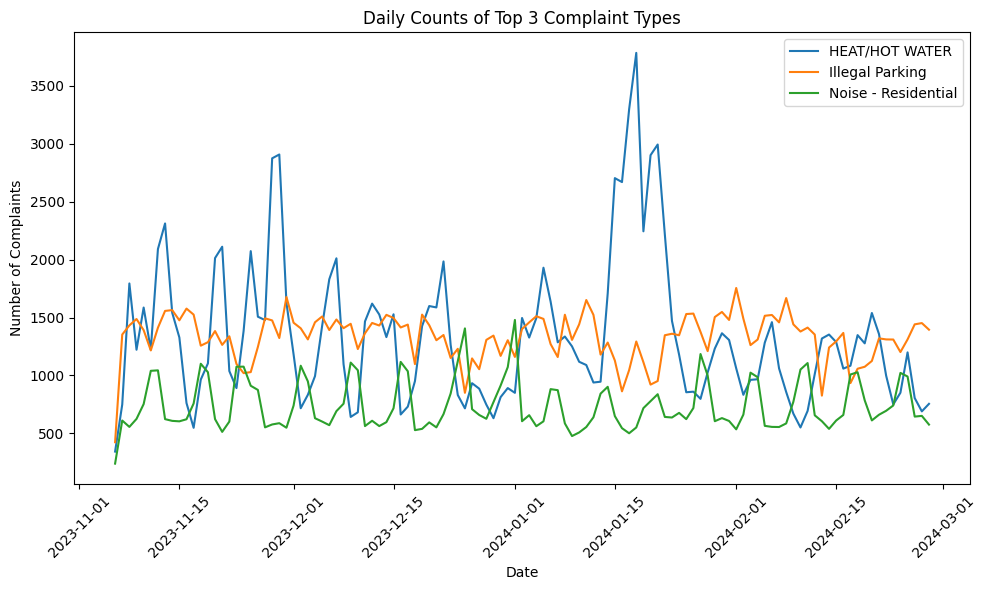

In [165]:
# Visualization 1: Complaint Types Over Time
def plot_top_complaints_over_time(engine: Engine):
    # Query to find top 3 complaint types
    top_complaints_query = """
        SELECT complaint_type, COUNT(*) as count
        FROM complaints_data
        WHERE created_date >= '2023-03-01' AND created_date <= '2024-02-29'
        GROUP BY complaint_type
        ORDER BY count DESC
        LIMIT 3;
    """
    top_complaints = read_query(top_complaints_query, engine)
    
    if top_complaints.empty:
        print("No data found for top complaints.")
        return

    # Prepare the tuple for SQL IN condition
    top_types_tuple = tuple(top_complaints['complaint_type'].tolist()) if len(top_complaints) > 1 else (top_complaints['complaint_type'].iloc[0],)
    
    # Query to get daily counts for these top complaint types
    complaint_trends_query = f"""
        SELECT created_date, complaint_type, COUNT(*) as daily_count
        FROM complaints_data
        WHERE complaint_type IN {top_types_tuple} AND
              created_date >= '2023-03-01' AND created_date <= '2024-02-29'
        GROUP BY created_date, complaint_type
        ORDER BY created_date;
    """
    complaint_trends = read_query(complaint_trends_query, engine)
    
    if complaint_trends.empty:
        print("No trend data found.")
        return

    complaint_trends['date'] = pd.to_datetime(complaint_trends['created_date'])

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    for ctype in top_complaints['complaint_type']:
        data = complaint_trends[complaint_trends['complaint_type'] == ctype]
        ax.plot(data['date'], data['daily_count'], label=ctype)
    
    ax.set_title('Daily Counts of Top 3 Complaint Types')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Complaints')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_top_complaints_over_time(engine)

### Visualization 2

1. **Querying the Data**:
   - The code executes a SQL query to get the top 10 complaint types in the zipcode '10027' between '2022-03-01' and '2024-02-29'.
   - The query counts the number of complaints for each complaint type and orders the results in descending order, limiting the output to the top 10.

2. **Preparing the Data**:
   - The function checks if the resulting dataframe is empty, and if so, it prints a message and returns.

3. **Visualizing the Data**:
   - The code creates a bar plot using Matplotlib to visualize the top 10 complaint types in zipcode '10027'.
   - The plot has a title, x-axis label (Complaint Type), y-axis label (Number of Complaints), and the x-axis tick labels are rotated 45 degrees for better readability.
   - The plot is displayed using `plt.show()`.

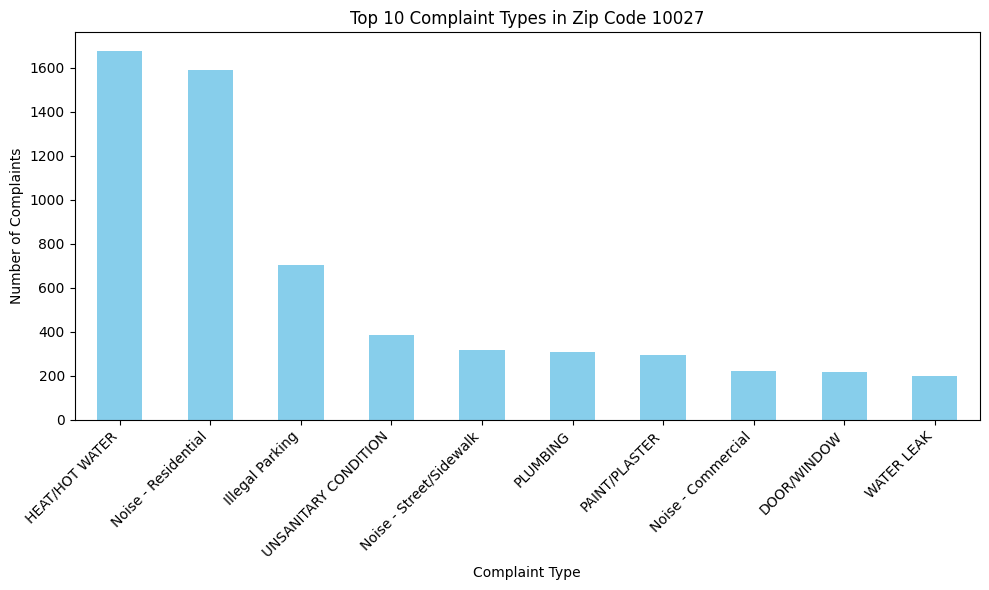

In [166]:
# Visualization 2: Complaints in Zip Code 10027
def plot_complaints_in_zip(engine: Engine):
    """
    Plots the top 10 complaint types in Zip Code 10027.
    
    Args:
        engine (Engine): The database engine connection used for querying data.
    """
    query = """
        SELECT complaint_type, COUNT(*) as count
        FROM complaints_data
        WHERE zipcode = '10027' AND
              created_date >= '2022-03-01' AND created_date <= '2024-02-29'
        GROUP BY complaint_type
        ORDER BY count DESC
        LIMIT 10;
    """
    df = read_query(query, engine)
    
    if df.empty:
        print("No data available to plot.")
        return

    # Plotting
    ax = df.plot(kind='bar', x='complaint_type', y='count', legend=None, figsize=(10, 6), color='skyblue')
    plt.title('Top 10 Complaint Types in Zip Code 10027')
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    ax.set_xticklabels(df['complaint_type'], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_complaints_in_zip(engine)

### Visualization 3

1. **Querying the Data**:
   - The code defines three separate functions to fetch data from the database:
     - `fetch_rent_data`: Retrieves the average rent price for each zipcode between '2022-02-01' and '2024-01-31'.
     - `fetch_tree_data`: Retrieves the count of trees for each zipcode.
     - `fetch_complaint_data`: Retrieves the count of complaints for each zipcode between '2022-02-01' and '2024-01-31'.

2. **Preparing the Data**:
   - The `plot_rent_trees_complaints_correlation` function calls the three data fetching functions and merges the resulting dataframes on the zipcode column.
   - If any of the dataframes are empty, the function prints a message and returns.
   - The function fills any NaN values in the merged dataframe with 0, as some zipcodes may not have data for one or more categories.

3. **Visualizing the Data**:
   - The function creates two subplots using Matplotlib, one for the correlation between average rent and tree count, and another for the correlation between average rent and complaint count.
   - The first subplot uses a scatter plot to show the relationship between average rent and tree count.
   - The second subplot uses a scatter plot to show the relationship between average rent and complaint count.
   - Both subplots have appropriate titles, x-axis labels (Average Rent), and y-axis labels (Tree Count and Complaint Count, respectively).
   - The plots are displayed using `plt.show()`.

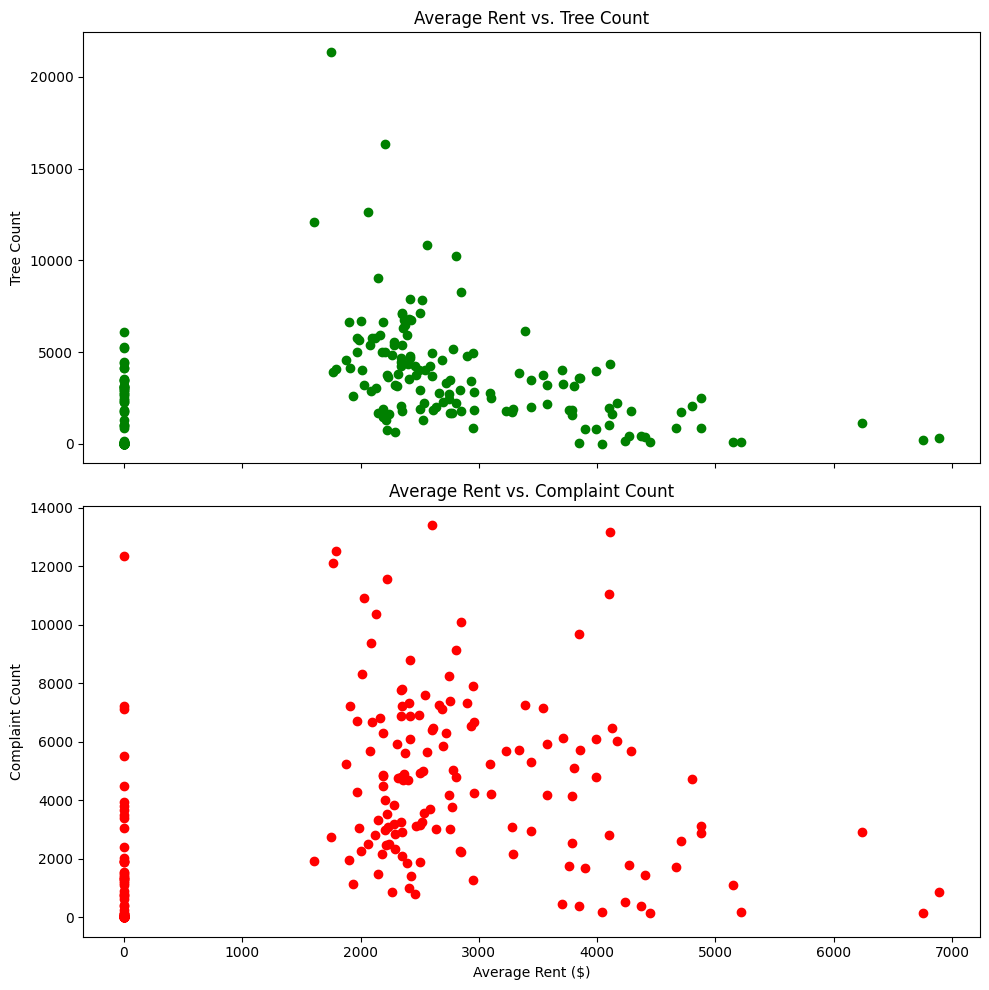

In [167]:
# Visualization 3: Correlation Between Rent, Trees, and Complaints
def fetch_rent_data(engine: Engine):
    rent_query = """
        SELECT zipcode, AVG(rent_price) as average_rent
        FROM zillow_data
        WHERE data_date BETWEEN '2022-02-01' AND '2024-01-31'
        GROUP BY zipcode;
    """
    return read_query(rent_query, engine)

def fetch_tree_data(engine: Engine):
    tree_query = """
        SELECT zipcode, COUNT(*) as tree_count
        FROM tree_data
        GROUP BY zipcode;
    """
    return read_query(tree_query, engine)

def fetch_complaint_data(engine: Engine):
    complaint_query = """
        SELECT zipcode, COUNT(*) as complaint_count
        FROM complaints_data
        WHERE created_date BETWEEN '2022-02-01' AND '2024-01-31'
        GROUP BY zipcode;
    """
    return read_query(complaint_query, engine)

def plot_rent_trees_complaints_correlation(engine: Engine):
    df_rent = fetch_rent_data(engine)
    df_trees = fetch_tree_data(engine)
    df_complaints = fetch_complaint_data(engine)

    if df_rent.empty or df_trees.empty or df_complaints.empty:
        print("One or more data sets are empty. Cannot plot correlation.")
        return

    # Merge dataframes on zipcode
    df = pd.merge(pd.merge(df_rent, df_trees, on='zipcode', how='outer'), df_complaints, on='zipcode', how='outer')
    df.fillna(0, inplace=True)  # Fill NaN values with 0 for zip codes with no data in one or more categories

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Plot Rent vs. Tree Count
    ax1.scatter(df['average_rent'], df['tree_count'], color='green')
    ax1.set_title('Average Rent vs. Tree Count')
    ax1.set_ylabel('Tree Count')

    # Plot Rent vs. Complaint Count
    ax2.scatter(df['average_rent'], df['complaint_count'], color='red')
    ax2.set_title('Average Rent vs. Complaint Count')
    ax2.set_xlabel('Average Rent ($)')
    ax2.set_ylabel('Complaint Count')

    plt.tight_layout()
    plt.show()

plot_rent_trees_complaints_correlation(engine)

### Visualization 4

1. **Querying the Data**:
   - The code defines a function `plot_rent_complaints_boxplot` that executes a SQL query to retrieve the following data:
     - The rent bin (in $1,000 increments) for each zipcode, based on the latest rent data (as of '2024-01-31').
     - The count of 311 complaints for each zipcode, where the complaints were created between '2023-02-01' and '2024-01-31'.

2. **Preparing the Data**:
   - The function checks if the resulting dataframe is empty, and if so, it prints a message and returns.
   - It then converts the 'rent_bin' column to an integer type to ensure proper axis labeling.

3. **Visualizing the Data**:
   - The function creates a boxplot using Seaborn to visualize the distribution of 311 complaint counts for each rent bin.
   - The plot has a title, 'Complaints by Rent Bins ($1000 increments)', and appropriate x-axis label ('Average Rent Bin ($)') and y-axis label ('Number of 311 Complaints').
   - The x-axis tick labels are formatted to display the rent bin values in a more readable format (e.g., '$1,000', '$2,000', etc.) and rotated 45 degrees.
   - The plot is displayed using `plt.show()`.

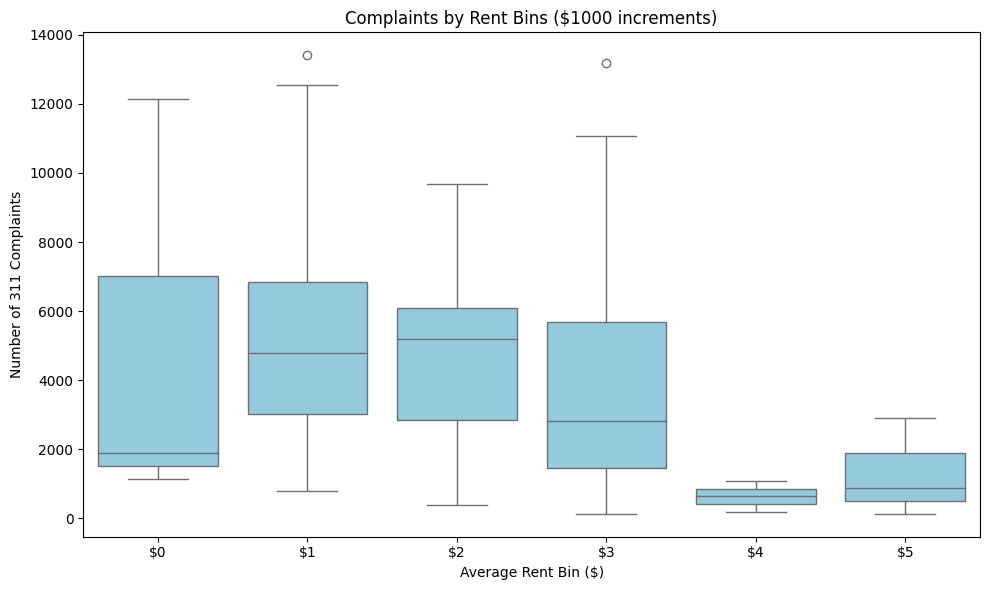

In [168]:
#Visualization 4: Rent vs Complaints by Rent Bins
def plot_rent_complaints_boxplot(engine: Engine):
    """
    Creates a boxplot showing the distribution of 311 complaints by different rent bins.
    
    Args:
        engine (Engine): The database engine connection used for querying data.
    """
    query = """
        SELECT floor(z.rent_price/1000)*1000 as rent_bin, COUNT(c.unique_id) as complaint_count
        FROM (SELECT * FROM zillow_data WHERE data_date = '2024-01-31') z
        JOIN complaints_data c ON z.zipcode = c.zipcode
        WHERE c.created_date BETWEEN '2023-02-01' AND '2024-01-31'
        GROUP BY z.zipcode, rent_bin
    """
    df = read_query(query, engine)
    
    if df.empty:
        print("No data available to plot.")
        return
    
    df['rent_bin'] = df['rent_bin'].astype(int)  # Ensure 'rent_bin' is an integer for better axis labeling
    
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='rent_bin', y='complaint_count', data=df, color='skyblue')
    ax.set_title('Complaints by Rent Bins ($1000 increments)')
    ax.set_xlabel('Average Rent Bin ($)')
    ax.set_ylabel('Number of 311 Complaints')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x):,}'))  # Improve label format
    
    plt.tight_layout()
    plt.show()

plot_rent_complaints_boxplot(engine)

### Visualization 5

1. **Querying the Data**:
   - The code defines a function `plot_geospatial_incidents` that executes a SQL query to retrieve the following data:
     - The complaint type, longitude, and latitude for 311 incidents that were created between '2023-03-01' and '2024-02-29', and are within a 1 km radius of a central point (specified in the query).

2. **Preparing the Data**:
   - The function checks if the resulting dataframe is empty, and if so, it prints a message and returns.
   - It then converts the dataframe to a GeoDataFrame, which is a special type of DataFrame that includes a geometry column for spatial data.

3. **Visualizing the Data**:
   - The function creates a new figure and axis using Matplotlib.
   - It then plots the 311 incident locations (represented as points) on the map using the `plot()` method of the GeoDataFrame.
   - The plot has a title, '311 Incidents within 1 km Radius of Central Point', and appropriate x-axis label ('Longitude') and y-axis label ('Latitude').
   - The plot is displayed using `plt.show()`.

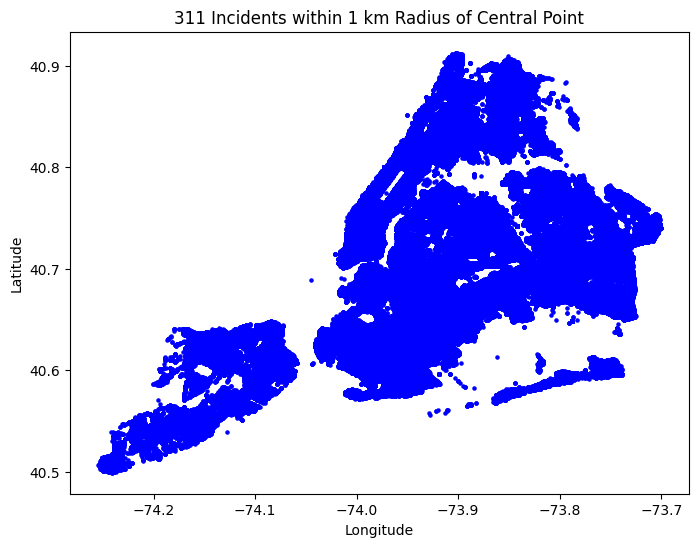

In [169]:
# Visualization 5: Geospatial Plot of 311 Incidents
def plot_geospatial_incidents(engine: Engine):
    """
    Plots 311 incidents within a 1 km radius of a central point using geospatial data.

    Args:
        engine (Engine): The database engine connection used for querying data.
    """
    query = """
    SELECT complaint_type, ST_X(geom) as longitude, ST_Y(geom) as latitude
    FROM complaints_data
    WHERE created_date BETWEEN '2023-03-01' AND '2024-02-29' AND ST_DWithin(geom, ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326), 1000)
    """
    df = read_query(query, engine)
    
    if df.empty:
        print("No data available to plot.")
        return

    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf.plot(ax=ax, marker='o', color='blue', markersize=5)
    ax.set_title('311 Incidents within 1 km Radius of Central Point')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_geospatial_incidents(engine)

### Visualization 6

1. **Querying the Data**:
   - The code defines a function `plot_trees_and_requests` that executes two SQL queries to retrieve the following data:
     - The longitude and latitude for existing trees in the tree_data table.
     - The longitude and latitude for new tree requests in the complaints_data table, where the complaint_type is 'New Tree Request' and the request was created between '2023-03-01' and '2024-02-29'.

2. **Preparing the Data**:
   - The function checks if the resulting dataframes for trees and requests are empty, and if so, it prints a message and returns.
   - It then converts the dataframes to GeoDataFrames, which are special types of DataFrames that include a geometry column for spatial data.

3. **Visualizing the Data**:
   - The function creates a new figure and axis using Matplotlib.
   - It then plots the existing trees and new tree requests on the map using the `plot()` method of the GeoDataFrames.
   - The trees are represented as green circles, and the new tree requests are represented as red 'x' markers.
   - The plot has a title, 'Trees and New Tree Requests in NYC', and appropriate x-axis label ('Longitude') and y-axis label ('Latitude').
   - The plot includes a legend to distinguish between the existing trees and new tree requests.
   - The plot is displayed using `plt.show()`.

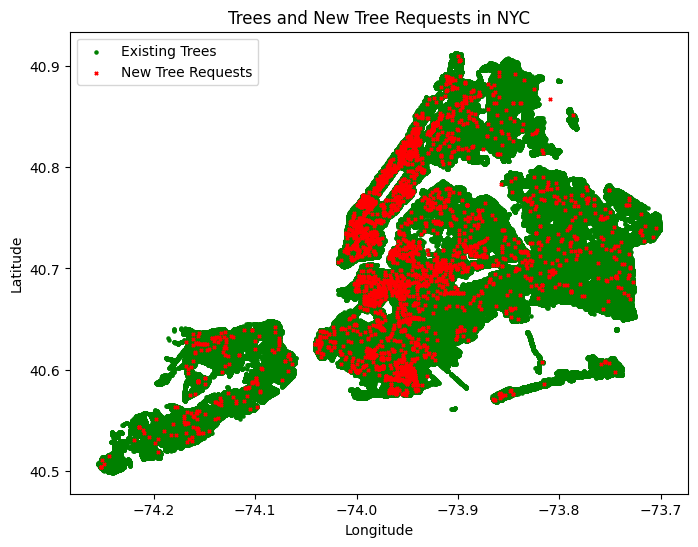

In [170]:
# Visualization 6: Tree Data and New Tree Requests
def plot_trees_and_requests(engine: Engine):
    """
    Plots existing trees and new tree requests in New York City on a geospatial map.
    
    Args:
        engine (Engine): The database engine connection used for querying data.
    """
    tree_query = """
    SELECT ST_X(geom) as longitude, ST_Y(geom) as latitude
    FROM tree_data
    """
    df_t = read_query(tree_query, engine)
    if df_t.empty:
        print("No tree data available to plot.")
        return
    trees = gpd.GeoDataFrame(df_t, geometry=gpd.points_from_xy(df_t['longitude'], df_t['latitude']))

    request_query = """
    SELECT ST_X(geom) as longitude, ST_Y(geom) as latitude
    FROM complaints_data
    WHERE complaint_type = 'New Tree Request' AND created_date BETWEEN '2023-03-01' AND '2024-02-29'
    """
    df_r = read_query(request_query, engine)
    if df_r.empty:
        print("No request data available to plot.")
        return
    requests = gpd.GeoDataFrame(df_r, geometry=gpd.points_from_xy(df_r['longitude'], df_r['latitude']))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    trees.plot(ax=ax, marker='o', color='green', markersize=5, label='Existing Trees')
    requests.plot(ax=ax, marker='x', color='red', markersize=5, label='New Tree Requests')
    ax.set_title('Trees and New Tree Requests in NYC')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    plt.show()

plot_trees_and_requests(engine)